In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from astropy.time import Time
from lsst.rsp import get_tap_service
import lsst.sphgeom as spgeom

np.random.seed(0)
service = get_tap_service("tap")

# Anomalies toy dataset

The goal of this notebook is to create a toy source dataset representative of the LSST-DP1.
The recipe is this:
1. We load visits and sources from the DP1 over the ECDFS field.
2. Over each visit's region we generate a number of random sources equal to the number of the (filtered) diaSources from that visit.
3. We generate a number of "true" fixed sources measurements.

## Loading model data

In [2]:
target_ra, target_dec, target_radius = 53.160, -28.100, 1.000
target_bands = ("g", "r", "i")
t1 = Time("2024-11-09T06:00:00.0", format="isot", scale="tai")
t2 = Time("2024-12-11T05:59:43.0", format="isot", scale="tai")

In [3]:
bands_str = "(" + ", ".join(f"'{b}'" for b in target_bands) + ")"
ccdVisit_astropy = service.search(
    f"SELECT * "
    f"FROM dp1.CcdVisit "
    # visit axis lies in target area
    f"WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {target_ra}, {target_dec}, {target_radius}))=1 "
    # filters bands outside selection
    f"AND band IN {bands_str} "
    # sorted by time
    f"ORDER BY obsStartMJD"
).to_table()
ccdVisit_df = ccdVisit_astropy.to_pandas()
ccdVisit_df = ccdVisit_df[(ccdVisit_df["obsStartMJD"] > t1.mjd) & (ccdVisit_df["obsStartMJD"] <= t2.mjd)]
ccdVisit_df = ccdVisit_df.set_index("ccdVisitId")
ccdVisit_df

,astromOffsetMean,astromOffsetStd,band,darkTime,dec,detector,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,...,urcdec,urcra,xSize,ySize,zenithDistance,zeroPoint,visitId,expMidptMJD,expMidpt,obsStartMJD
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
1145019888896,0.013189,0.007590,i,30.4550,-28.190331,0,21.713400,0.678940,1.113840,0.957091,...,-28.104861,53.156342,4071,3999,15.812000,31.839001,2024110800245,60623.258521,2024-11-09T06:12:16.184,60623.258347
1145019888897,0.008955,0.004623,i,30.4550,-27.961231,1,23.941300,0.747191,1.116480,0.956626,...,-27.875887,53.215842,4071,3999,15.809600,31.838699,2024110800245,60623.258521,2024-11-09T06:12:16.184,60623.258347
1145019888898,0.008094,0.003990,i,30.4550,-27.731684,2,22.804500,0.712375,1.119730,0.952960,...,-27.646045,53.274910,4071,3999,15.810800,31.836599,2024110800245,60623.258521,2024-11-09T06:12:16.184,60623.258347
1145019888899,0.008272,0.004680,i,30.4550,-28.242508,3,21.904600,0.686210,1.113860,0.955270,...,-28.156717,53.416250,4071,3999,15.576900,31.837999,2024110800245,60623.258521,2024-11-09T06:12:16.184,60623.258347
1145019888900,0.007791,0.004566,i,30.4550,-28.013505,4,24.859600,0.776246,1.115060,0.957363,...,-27.927729,53.474983,4071,3999,15.574700,31.839100,2024110800245,60623.258521,2024-11-09T06:12:16.184,60623.258347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145288372740,0.022415,0.013270,g,30.4376,-28.087315,4,0.339537,0.204529,0.201259,0.274952,...,-28.036404,53.434395,4071,3999,40.109200,31.501900,2024121000434,60655.249976,2024-12-11T05:59:57.942,60655.249803
1145288372741,0.027347,0.017038,g,30.4376,-27.877433,5,0.309740,0.206433,0.200344,0.249643,...,-27.826325,53.554171,4071,3999,40.060001,31.449499,2024121000434,60655.249976,2024-12-11T05:59:57.942,60655.249803
1145288372742,0.020092,0.011220,g,30.4376,-28.403172,6,0.250884,0.190129,0.192209,0.228838,...,-28.352215,53.552697,4071,3999,39.930099,31.402201,2024121000434,60655.249976,2024-12-11T05:59:57.942,60655.249803


In [4]:
ccdVisit_ids = ccdVisit_df["visitId"].unique()
ccdVisit_ids_str = "(" + ", ".join(map(str, ccdVisit_ids)) + ")"
job = service.submit_job(
    f"SELECT * "
    f"FROM dp1.DiaSource "
    f"WHERE visit IN {ccdVisit_ids_str}"
)
# query is larg-ish, so we launch the job as async
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
diaSource_df = job.fetch_result().to_table().to_pandas()

Job phase is COMPLETED


In [5]:
diaSource_df = diaSource_df.set_index("diaSourceId")

In [6]:
def verbose(func):
    def msg_wrapper(df: pd.DataFrame, *args, **kwargs):
        len_before, len_before_cols = len(df), len(df.columns)

        df = func(df, *args, *kwargs)
        if (diff := len_before - len(df)):
            print(f"{func.__name__} {'cut' if diff > 0 else 'added'} {abs(diff)} rows ({100 * float(abs(diff / len_before)):.2f} %, originally: {len_before})")
        if (diff := len_before_cols - len(df.columns)):
            print(f"{func.__name__} {'cut' if diff > 0 else 'added'} {abs(diff)} columns (originally: {len_before_cols})")
        return df
    return msg_wrapper


flag_columns = [
    "pixelFlags_cr",
    "pixelFlags_crCenter",
    "centroid_flag",
    "apFlux_flag",
    "isDipole",
    # next flags are from Liu 2024
    "pixelFlags_saturated",
    "pixelFlags_saturatedCenter",
    "pixelFlags_suspect",
    "pixelFlags_suspectCenter",
    "pixelFlags_streak",
    "pixelFlags_streakCenter",
    "pixelFlags_offimage",
    "pixelFlags_bad",
    "psfFlux_flag",
    "shape_flag",
]

def filter_flags(df: pd.DataFrame, flag_columns: list[str]) -> pd.DataFrame:
    for flag in flag_columns:
        def filter_func(df: pd.DataFrame, flag_name: str = flag) -> pd.DataFrame:
            return df[~df[flag_name]]
        
        filter_func.__name__ = f"filter_{flag}"
        df = verbose(filter_func)(df)
    return df
    

@verbose
def filter_nans(df: pd.DataFrame) -> pd.DataFrame:
    return df.dropna(subset=["ra", "dec", "raErr", "decErr"])


# diaSource_df = filter_nans(filter_flags(diaSource_df))
diaSource_df = filter_nans(filter_flags(diaSource_df, flag_columns))

filter_pixelFlags_cr cut 2586 rows (0.69 %, originally: 374712)
filter_centroid_flag cut 68957 rows (18.53 %, originally: 372126)
filter_apFlux_flag cut 114 rows (0.04 %, originally: 303169)
filter_isDipole cut 142197 rows (46.92 %, originally: 303055)
filter_pixelFlags_saturated cut 4253 rows (2.64 %, originally: 160858)
filter_pixelFlags_suspect cut 398 rows (0.25 %, originally: 156605)
filter_pixelFlags_streak cut 1893 rows (1.21 %, originally: 156207)
filter_shape_flag cut 48611 rows (31.50 %, originally: 154314)
filter_nans cut 55 rows (0.05 %, originally: 105703)


## Dataset generation

First, for every visit, we compute its spherical polygon region.

In [7]:
def vertices_to_region(
    v1: tuple[float, float],
    v2: tuple[float, float],
    v3: tuple[float, float],
    v4: tuple[float, float],
):
    """Creates a ConvexPolygon region from four vertices in (lon, lat) degrees."""
    return spgeom.ConvexPolygon(
        [*map(
            lambda x: spgeom.UnitVector3d(spgeom.LonLat.fromDegrees(*x)),
            [v1, v2, v3, v4],
        )]
    )

def ccdVisit_to_region(ccdVisit: pd.Series):
    """Converts a ccdVisit Series with corner coordinates to a ConvexPolygon region."""
    return vertices_to_region(
        ccdVisit[["llcra", "llcdec",]],
        ccdVisit[["lrcra", "lrcdec",]],
        ccdVisit[["ulcra", "ulcdec",]],
        ccdVisit[["urcra", "urcdec",]],
    )


regions = {}
for _, ccdVisit in tqdm(ccdVisit_df.iterrows(), total=len(ccdVisit_df)):
    regions[*ccdVisit[["visitId", "detector"]]] = ccdVisit_to_region(ccdVisit)

  0%|          | 0/5658 [00:00<?, ?it/s]

Now we write code for generating a number of random sources over each region.

In [8]:
def _sph2xyz(coords: np.array) -> np.array:
    """Converts spherical coordinates (lon, lat in degrees) to cartesian on unit sphere."""
    lons = np.deg2rad(coords[:, 0])
    lats = np.deg2rad(coords[:, 1])

    x = (cos_lat_rad := np.cos(lats)) * np.cos(lons)
    y = cos_lat_rad * np.sin(lons)
    z = np.sin(lats)
    return np.column_stack([x, y, z])


def _xyz2sph(coords: np.array) -> np.array:
    """Converts cartesian coordinates to spherical (lon, lat in degrees) on unit sphere."""
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
    
    lats = np.rad2deg(np.arcsin(z))
    lons = np.rad2deg(np.arctan2(y, x))
    
    return np.column_stack([lons, lats])

    
def rotmatx(coords: np.array, alpha: float) -> np.array:
    """Rotates N cartesian coordinates around x-axis by alpha degrees."""
    alpha_rad = np.radians(alpha)
    cos_a = np.cos(alpha_rad)
    sin_a = np.sin(alpha_rad)
    
    R_x = np.array([
        [1,     0,      0],
        [0,  cos_a, -sin_a],
        [0,  sin_a,  cos_a]
    ])
    
    return coords @ R_x.T


def rotmaty(coords: np.array, alpha: float) -> np.array:
    """Rotates N cartesian coordinates around y-axis by alpha degrees."""
    alpha_rad = np.radians(alpha)
    cos_a = np.cos(alpha_rad)
    sin_a = np.sin(alpha_rad)
    
    R_y = np.array([
        [ cos_a,  0,  sin_a],
        [    0,   1,     0],
        [-sin_a,  0,  cos_a]
    ])
    
    return coords @ R_y.T


def rotmatz(coords: np.array, alpha: float) -> np.array:
    """Rotates N cartesian coordinates around z-axis by alpha degrees."""
    alpha_rad = np.radians(alpha)
    cos_a = np.cos(alpha_rad)
    sin_a = np.sin(alpha_rad)
    
    R_z = np.array([
        [cos_a, -sin_a,  0],
        [sin_a,  cos_a,  0],
        [   0,      0,   1]
    ])
    
    return coords @ R_z.T


def _random_points(npoints: int, side: float) -> np.array:
    """Generates random points uniformly distributed on a spherical patch of given side (degrees)."""
    ramin, ramax = -np.radians(side / 2), np.radians(side / 2)
    decmin, decmax = -np.radians(side / 2), np.radians(side / 2)
    ras = (ramax - ramin) * np.random.rand(npoints) + ramin
    decs = np.arcsin(np.random.uniform(np.sin(decmin), np.sin(decmax), npoints))
    return np.column_stack([np.degrees(ras), np.degrees(decs)])



def rand_sphrect(npoints: int, side: float, ra: float, dec: float, rot: float) -> np.array:
    """Generates random points over spherical rectangle at given ra, dec with rotation.
    
    Creates a uniformly distributed set of points on a spherical patch, then applies
    rotations to position and orient the patch at the specified celestial coordinates.
    
    Args:
        npoints (int): Number of random points to generate.
        side (float): Side length of the spherical rectangle in degrees.
        ra (float): Right ascension of the patch center in degrees.
        dec (float): Declination of the patch center in degrees.
        rot (float): Sky rotation angle in degrees (field rotation).
    
    Returns:
        np.array: Array of shape (npoints, 2) containing [longitude, latitude] 
                  coordinates in degrees for each point.
    """
    return _xyz2sph(
        rotmatz(
            rotmaty(
                rotmatx(
                    _sph2xyz(_random_points(npoints, side)), 
                    -rot), 
                -dec), 
            ra)
    )


SIDE_VISIT = 13.7 * 1. / 60.

ccdVisit = ccdVisit_df.iloc[522]
ra, dec, rot = ccdVisit[["ra", "dec", "skyRotation"]]
region = ccdVisit_to_region(ccdVisit)
points = rand_sphrect(1000, SIDE_VISIT, ra, dec, rot)

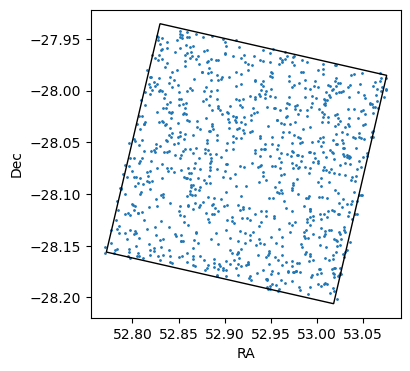

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import lsst.geom as geom


fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(points[:,0], points[:,1], s=1)
vertices = [
    [(_sp := geom.SpherePoint(v)).getRa().asDegrees(), _sp.getDec().asDegrees()]
    for v in region.getVertices()
]
ax.add_patch(Polygon(vertices, closed=True, facecolor="None", edgecolor="k", alpha=1.))
ax.set(xlabel="RA", ylabel="Dec")
plt.show()

And prepare code for associating errors on the RA and declination coordinate by sampling the DP1-ECDFS distribution.

In [10]:
def inversion_sampling(
    size: int,
    probability: np.ndarray,
    bins: np.ndarray,
) -> np.ndarray:
    """
    Fast inversion sampling from discrete distribution.
    Does not require bins to be equispaced.
    """
    probability_cdf = np.cumsum(probability)
    ys = np.random.rand(size) * probability_cdf[-1]
    ii = np.searchsorted(probability_cdf, ys)
    top_edges = bins[ii + 1]
    samples = top_edges - np.random.rand(size) * (top_edges - bins[ii])
    if size == 1:
        return samples[0].item(), ii[0].item()
    return samples, ii

In [11]:
counts_ra, bins_ra = np.histogram(_raErrs := diaSource_df["raErr"],  bins=np.linspace(0, np.quantile(_raErrs, 0.99), 100))
counts_dec, bins_dec = np.histogram(_decErrs := diaSource_df["decErr"],  bins=np.linspace(0, np.quantile(_decErrs, 0.99), 100))

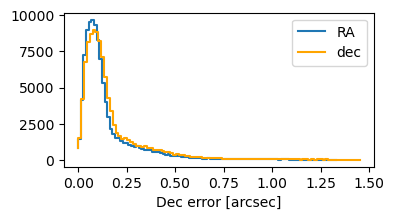

In [12]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.step(bins_ra[:-1] * 3600, counts_ra, label="RA")
ax.step(bins_dec[:-1] * 3600, counts_dec, c="orange", label="dec")
ax.set_xlabel("Dec error [arcsec]")
plt.legend()
plt.show()

### Generating fake visits

First we prepare a table of the visits starting from the `ccdVisit` DP1 table, which we fetched in advance.

In [13]:
visit_map = {}
visits_set = set()
for _, ccdVisit in ccdVisit_df.iterrows():
    visits_set |= {ccdVisit["visitId"]}
    visit_map[(ccdVisit["visitId"], ccdVisit["detector"])] = (len(visits_set) - 1, ccdVisit["detector"])

In [14]:
visits = []
for _, ccdVisit in tqdm(ccdVisit_df.iterrows(), total=len(ccdVisit_df)):
    visits += [[*visit_map[(ccdVisit["visitId"], ccdVisit["detector"])], *ccdVisit[["ra", "dec", "skyRotation"]]]]

visits_df = pd.DataFrame(visits, columns=["visit", "detector", "ra", "dec", "rotation"])
visits_df = visits_df.astype({
    "visit": int,
    "detector": int,
    "ra": float,
    "dec": float,
    "rotation": float
})

  0%|          | 0/5658 [00:00<?, ?it/s]

In [15]:
visits_df

,visit,detector,ra,dec,rotation
0,0,0,53.004536,-28.190331,102.799379
1,0,1,53.064355,-27.961231,102.799379
2,0,2,53.123909,-27.731684,102.799379
3,0,3,53.264695,-28.242508,102.799379
4,0,4,53.323752,-28.013505,102.799379
...,...,...,...,...,...
5653,628,4,53.264000,-28.087315,116.813903
5654,628,5,53.384052,-27.877433,116.813903
5655,628,6,53.381747,-28.403172,116.813903
5656,628,7,53.502178,-28.193170,116.813903


### Generating noise sources

Now it's time to use the code above for generating the random noise sources over each visit region.

In [16]:
SIDE_VISIT = 13.7 * 1. / 60.
_map = {v: k for k, v in visit_map.items()}

noise = []
for _, visit_row in tqdm(visits_df.iterrows(), total=len(visits_df)):
    visit, detector = visit_row[["visit", "detector"]]    
    diaSources = diaSource_df[
        (diaSource_df["visit"] == (_v := _map[(visit, detector)])[0]) & 
        (diaSource_df["detector"] == _v[1])
    ]
    npoints = len(diaSources)
    points = rand_sphrect(npoints, SIDE_VISIT, *visit_row[["ra", "dec", "rotation"]])
    ra_err, _ = inversion_sampling(npoints, counts_ra, bins_ra) 
    dec_err, _ = inversion_sampling(npoints, counts_dec, bins_dec) 
    noise += [np.column_stack((
        np.ones(len(points)) * visit, 
        np.ones(len(points)) * detector, 
        points, 
        ra_err, 
        dec_err
    ))]

noise = np.vstack(noise)
noise_df = pd.DataFrame(noise, columns=["visit", "detector", "ra", "dec", "ra_err", "dec_err"])
noise_df = noise_df.astype({
    "visit": int,
    "detector": int,
    "ra": float,
    "dec": float,
    "ra_err": float,
    "dec_err": float
})

  0%|          | 0/5658 [00:00<?, ?it/s]

In [17]:
noise_df

,visit,detector,ra,dec,ra_err,dec_err
0,0,0,52.934216,-28.249183,0.000031,0.000139
1,0,0,52.941750,-28.172142,0.000036,0.000052
2,0,0,53.024211,-28.199691,0.000135,0.000033
3,0,0,52.957757,-28.122534,0.000035,0.000064
4,0,0,52.991781,-28.212373,0.000153,0.000016
...,...,...,...,...,...,...
105643,628,8,53.650513,-27.993877,0.000005,0.000039
105644,628,8,53.752758,-27.978970,0.000016,0.000042
105645,628,8,53.656068,-27.894557,0.000011,0.000013
105646,628,8,53.495551,-27.998640,0.000026,0.000106


### Generating true sources

It's time to deal with the true sources. First we sample onset times randomly.

In [18]:
NSOURCES = 66

trues = []
random_visits = visits_df.loc[np.random.choice(visits_df.index, NSOURCES)].sort_values("visit")
for i, onset_visit in random_visits.iterrows():
    ra, dec = rand_sphrect(1, SIDE_VISIT, *onset_visit[["ra", "dec", "rotation"]])[0]
    trues += [[onset_visit["visit"], ra, dec]]
    
trues_df = pd.DataFrame(trues, columns=["onset_visit", "ra", "dec"])
trues_df = trues_df.astype({
    "onset_visit": int,
    "ra": float,
    "dec": float,
})

In [19]:
trues_df

,onset_visit,ra,dec
0,2,52.745269,-28.036714
1,8,52.586902,-27.930479
2,10,53.270178,-28.156998
3,47,53.627362,-27.966120
4,49,53.111864,-27.803252
...,...,...,...
61,590,53.111515,-27.995102
62,591,52.841372,-27.950508
63,594,53.094000,-28.270791
64,621,53.071310,-27.845582


### Generating true sources measures

Than we generate the actual measurements from the true sources. We define `PROBABILISTIC_CUT` so that there is a non-zero change of not observing a source over two consecutive visit of the same sky coordinate.

In [20]:
PROBABILISTIC_CUT = 0.05
_map = {v: k for k, v in visit_map.items()}

def generate_candidate(true_ra, true_dec, ra_err, dec_err):
    std = np.random.normal()
    alpha = np.random.rand() * 2. * np.pi
    ra =  true_ra + std * ra_err * np.cos(alpha)
    dec = true_dec + std * dec_err * np.sin(alpha)
    return ra, dec

def region_contains(region, ra, dec):
    return region.contains(
        spgeom.UnitVector3d(spgeom.LonLat.fromDegrees(ra, dec))
    )

signal = []
for _, source in tqdm(trues_df.iterrows(), total=len(trues_df)):
    for _, visit in visits_df[visits_df["visit"] >= source["onset_visit"]].iterrows():
        _r = regions[_map[*visit[["visit", "detector"]]]]
        if region_contains(_r, *source[["ra", "dec"]]):
            if np.random.rand() < PROBABILISTIC_CUT:
                continue
            ra_err, _ = inversion_sampling(1, counts_ra, bins_ra) 
            dec_err, _ = inversion_sampling(1, counts_dec, bins_dec)
            ra, dec = generate_candidate(source["ra"], source["dec"], ra_err, dec_err)
            while not region_contains(_r, ra, dec):
                ra, dec =generate_candidate(source["ra"], source["dec"], ra_err, dec_err)
            signal += [[*visit[["visit", "detector"]], ra, dec, ra_err, dec_err]]


signal = np.vstack(signal)
signal_df = pd.DataFrame(signal, columns=["visit", "detector", "ra", "dec", "ra_err", "dec_err"])
signal_df = signal_df.astype({
    "visit": int,
    "detector": int,
    "ra": float,
    "dec": float,
    "ra_err": float,
    "dec_err": float
})

  0%|          | 0/66 [00:00<?, ?it/s]

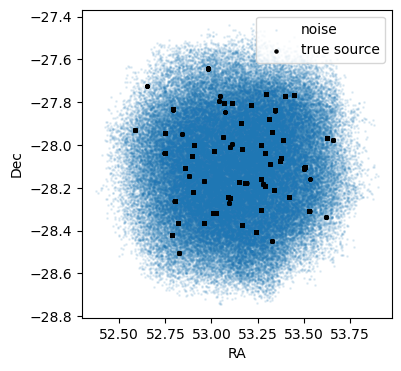

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import lsst.geom as geom


fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(noise_df["ra"], noise_df["dec"], s=1, alpha=0.1, label="noise")
ax.scatter(signal_df["ra"], signal_df["dec"], s=5, color="k", label="true source")
ax.set(xlabel="RA", ylabel="Dec")
plt.legend()
plt.show()

### Putting things together

Finally its time to catalog each source as true or noise (for future benchmarking) and to output the source table. 

In [22]:
signal_df["is_true"] = True

In [23]:
noise_df["is_true"] = False

In [24]:
df = pd.concat((noise_df, signal_df))
df = df.sample(frac=1).sort_values(["visit", "detector"])
df = df.reset_index(drop=True)

In [25]:
df

,visit,detector,ra,dec,ra_err,dec_err,is_true
0,0,0,52.947247,-28.218183,0.000046,0.000043,False
1,0,0,53.117078,-28.188512,0.000034,0.000009,False
2,0,0,52.953142,-28.251482,0.000149,0.000061,False
3,0,0,53.026706,-28.145031,0.000018,0.000105,False
4,0,0,52.933482,-28.280020,0.000093,0.000163,False
...,...,...,...,...,...,...,...
118823,628,8,53.495551,-27.998640,0.000026,0.000106,False
118824,628,8,53.597428,-27.992320,0.000022,0.000038,False
118825,628,8,53.658306,-27.976720,0.000038,0.000008,True
118826,628,8,53.627362,-27.966119,0.000051,0.000026,True


In [26]:
df.to_csv("toydataset/sources.csv", index=False)